## Importing Modules

In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import nltk
import pandas as pd

### Load Dataset into Dataframe

In [2]:
df= pd.read_csv("/home/shakeer/Downloads/data.csv")

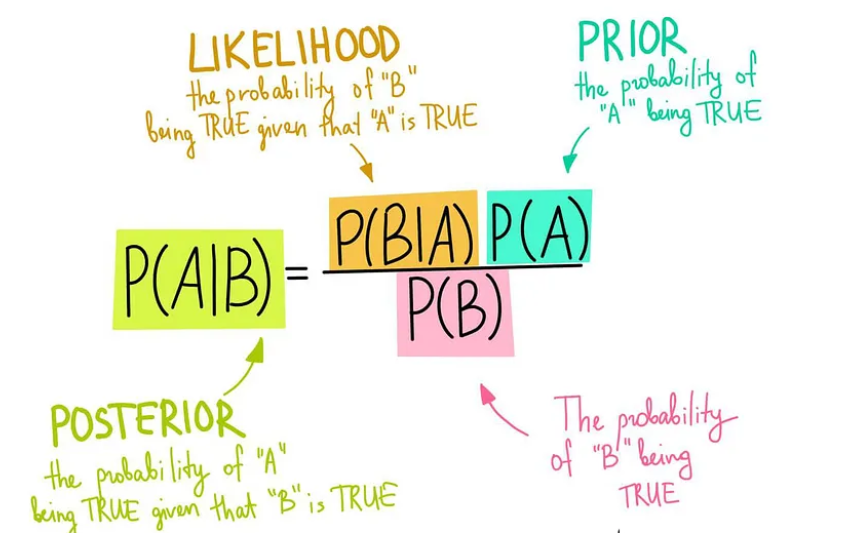

## Exploring Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [4]:
df.columns

Index(['Sentence', 'Sentiment'], dtype='object')

In [5]:
df.describe()

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,Managing Director 's comments : `` Net sales f...,neutral
freq,2,3130


## Visualizing the Sentence and Sentiment Data

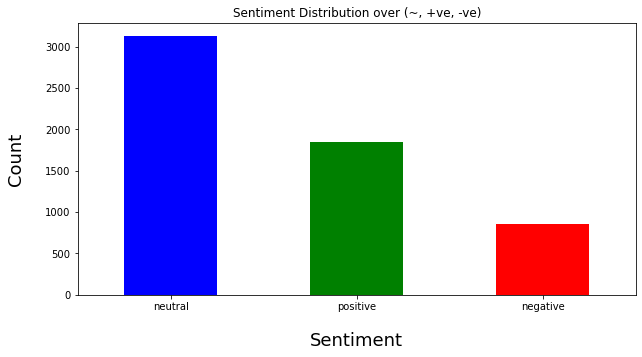

In [6]:
sentiment_counts = df['Sentiment'].value_counts()
plt.figure(figsize=(10,5))
sentiment_counts.plot(kind='bar', color=['blue', 'green', 'red'])  #line', 'bar', 'barh', 'kde', 'density', 'area', 'hist', 'box', 'pie', 'scatter', 'hexbin
plt.title('Sentiment Distribution over (~, +ve, -ve)')
plt.xlabel('Sentiment',labelpad=20, fontsize=18)
plt.ylabel('Count',labelpad=20, fontsize=18)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()

In [7]:
round((df.isnull().sum()/df.shape[0])*100) #check null values / missing values

Sentence     0.0
Sentiment    0.0
dtype: float64

In [8]:
print("No of Rows in Original Dataset: ",len(df)) 

No of Rows in Original Dataset:  5842


## Removal of duplicate rows

In [9]:
duplicate_rows = df[df.duplicated()]
print("Duplicate Rows:")
print(duplicate_rows)
#print(df['Sentiment'][234])

Duplicate Rows:
                                               Sentence Sentiment
1825  Proha Plc ( Euronext :7327 ) announced today (...   neutral
1859  SSH Communications Security Corporation is hea...   neutral
2672  Ahlstrom 's share is quoted on the NASDAQ OMX ...   neutral
3272  The company serves customers in various indust...   neutral
3986  The issuer is solely responsible for the conte...   neutral
5342  The report profiles 614 companies including ma...   neutral


In [10]:
df.drop_duplicates(inplace=True)

In [11]:
print("No of Rows after dropping duplicate rows : ",len(df))

No of Rows after dropping duplicate rows :  5836


In [12]:
sentiment = {
    'negative':0,
    'neutral' :1,
    'positive':2
}

In [13]:
df['Sentiment'] = df['Sentiment'].apply(lambda x:sentiment[x])
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,2
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0
2,"For the last quarter of 2010 , Componenta 's n...",2
3,According to the Finnish-Russian Chamber of Co...,1
4,The Swedish buyout firm has sold its remaining...,1


## Splitting Train and Test data from Dataset

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [15]:
X_train,X_test,y_train,y_test = train_test_split(df['Sentence'],df['Sentiment'],
                                                 test_size =0.2,stratify=df['Sentiment'],random_state=42)
X_train.shape, X_test.shape, y_train.shape,y_test.shape

((4668,), (1168,), (4668,), (1168,))

## Setting Vocabulary from Training Set

In [16]:
vocab = set()
for text in X_train:
    vocab.update(text.split())
vocab = list(vocab)
#print(vocab)

## Naive Bayes Model

In [17]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import numpy as np

class NaiveBayesClassifier:
    def __init__(self, classes):
        self.classes = classes
        self.class_priors = {}
        self.word_counts = {}
        self.word_probs = {}
        self.vocab = []

    def preprocess_text(self, text):
        stop_words = set(stopwords.words('english'))
        ps = PorterStemmer()
        words = nltk.word_tokenize(text.lower())
        words = [ps.stem(word) for word in words if word.isalpha() and word not in stop_words]
        return words

    def fit(self, X, y, vocab):
        self.vocab = vocab
        vocab_size = len(vocab)

        self.word_counts = {c: np.zeros(vocab_size) for c in self.classes}
        self.word_probs = {c: np.zeros(vocab_size) for c in self.classes}

        for c in self.classes:
            total_count = np.sum(y == c)
            self.class_priors[c] = total_count / len(y)
            class_texts = X[y == c]
            class_words = []
            for text in class_texts:
                class_words.extend(self.preprocess_text(text))
            for word in class_words:
                if word in vocab:
                    self.word_counts[c][vocab.index(word)] += 1

            total_words = np.sum(self.word_counts[c])
            self.word_probs[c] = (self.word_counts[c] + 1) / (total_words + vocab_size) # Laplace Smoothing

    def predict_proba(self, X):
        probas = []
        for text in X:
            words = self.preprocess_text(text)
            scores = {}
            for c in self.classes:
                log_prob = np.log(self.class_priors[c])
                for word in words:
                    if word in self.vocab:
                        word_idx = self.vocab.index(word)
                        log_prob += np.log(self.word_probs[c][word_idx])
                scores[c] = log_prob
            exp_scores = {c: np.exp(score) for c, score in scores.items()}
            sum_exp_scores = sum(exp_scores.values())
            probas.append({c: exp_scores[c] / sum_exp_scores for c in self.classes})
        return probas


# Example usage:
# Build vocabulary
vocab = set()
for text in X_train:
    vocab.update(text.split())
vocab = list(vocab)

# Initialize and train the classifier
model = NaiveBayesClassifier(classes=[0,1,2])
model.fit(X_train, y_train, vocab)

# Predicting probabilities for a new text
new_text = "The group 's operating profit was EUR 0.8 mn , up from a profit of EUR 2.5 mn in 2004 ."
probas = model.predict_proba([new_text])[0]
print(f'Predicted Probabilities for "{new_text}": {probas}')


Predicted Probabilities for "The group 's operating profit was EUR 0.8 mn , up from a profit of EUR 2.5 mn in 2004 .": {0: 0.06272873880827608, 1: 0.4579654471132341, 2: 0.4793058140784898}


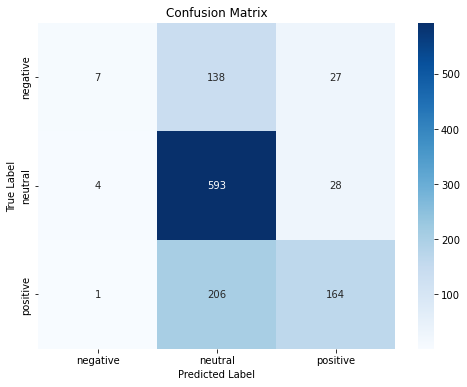

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict labels for the test set
y_pred_proba = model.predict_proba(X_test)
y_pred = [max(proba, key=proba.get) for proba in y_pred_proba]

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sentiment.keys(), yticklabels=sentiment.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
